In [1]:
from tg.grammar_ru.common import *
from tg.projects.alternative import BundleBuilder, BundleConfig
from tg.projects.alternative import EndingNegativeSampler
from tg.grammar_ru import features as fe

tsa_sampler = EndingNegativeSampler('тся','ться')


config = BundleConfig(
    [
        Loc.corpus_path/'pub.base.zip',
        Loc.corpus_path/'books.base.zip',
        Loc.corpus_path/'lenta.base.zip'
    ],
    None,
    tsa_sampler,
    [
        fe.PyMorphyFeaturizer(),
        fe.SlovnetFeaturizer(),
        fe.SyntaxTreeFeaturizer(),
        fe.SyntaxStatsFeaturizer()
        
    ],
    Loc.temp_path/'tsa/',
)

builder = BundleBuilder(config)

In [2]:
from typing import *
import pandas as pd
from tg.grammar_ru.algorithms import SpellcheckAlgorithm
import numpy as np
from yo_fluq_ds import *


def _count_verbs(dfs: Iterable[pd.DataFrame]):
    counter = {}
    for df in dfs:
        df = df.loc[df.word.str.endswith('тся') | df.word.str.endswith('ться')]
        for word in df.word.str.lower():
            counter[word] = counter.get(word,0)+1
    return counter


def _another(w):
    if w.endswith('тся'):
        return w.replace('тся', 'ться')
    else:
        return w.replace('ться', 'тся')


def _get_good_words_df(words):
    for w in list(words):
        if _another(w) not in words:
            words[_another(w)] = 0

    rows = []
    for w in words:
        if w.endswith('ться'):
            rows.append((w,_another(w),words[w], words[_another(w)]))

    df = pd.DataFrame(rows, columns=['i_word','f_word','i_cnt','f_cnt'])
    df['both_found'] = df[['i_cnt','f_cnt']].min(axis=1)>0
    df = df[df.both_found]
    df['ratio'] = np.minimum(df.i_cnt/df.f_cnt, df.f_cnt/df.i_cnt)

    alg = SpellcheckAlgorithm()
    for prefix in ['i_', 'f_']:
        xdf = pd.DataFrame(dict(word=df[prefix+'word'], word_type='ru'))
        kdf = alg.run(DataBundle(src=xdf))
        df[prefix+'spell'] = ~kdf.error

    df['both_correct'] = df.i_spell & df.f_spell
    df = df.loc[df.both_correct]
    return df


def build_dictionary(dfs):
    cnt = _count_verbs(dfs)
    df = _get_good_words_df(cnt)
    good_words = set(df.i_word).union(df.f_word)
    return good_words

dict_path = Loc.data_cache_path/'tasks/tsa-dict.json'
os.makedirs(dict_path.parent, exist_ok = True)
if not os.path.isfile(dict_path):
    tsa_dict = build_dictionary(builder.get_all_frames(True))
    FileIO.write_json(list(tsa_dict), dict_path)
else:
    tsa_dict = FileIO.read_json(dict_path)

In [3]:
from tg.projects.alternative import DictionaryFilterer

builder.config.filterer = DictionaryFilterer(tsa_dict)
buckets_path = Loc.data_cache_path/'tasks/tsa_buckets.parquet'
if not os.path.isfile(buckets_path):
    buckets = builder.compute_buckets()
    buckets.to_parquet(buckets_path)
else:
    buckets= pd.read_parquet(buckets_path)

In [4]:
buckets

,corpus_id,sentence_id,len,log_len
0,pub.base.zip,1,27,4
1,pub.base.zip,4,20,4
2,pub.base.zip,7,15,3
3,pub.base.zip,25,7,2
4,pub.base.zip,27,15,3
...,...,...,...,...
456855,lenta.base.zip,169870935,16,4
456856,lenta.base.zip,169870976,20,4
456857,lenta.base.zip,169871029,21,4
456858,lenta.base.zip,169871039,18,4


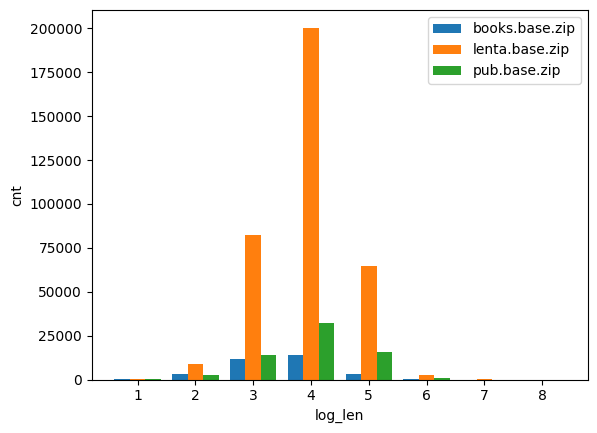

In [5]:
from tg.common.analysis import grbar_plot

ax = grbar_plot(
    buckets.groupby(['corpus_id','log_len']).size().to_frame('cnt').reset_index(),
    value_column='cnt',
    color_column='corpus_id',
    group_column='log_len'
)
ax.legend()

In [6]:
import numpy as np
df = buckets.copy()
df['random'] = np.random.rand(df.shape[0])
df = df.feed(fluq.add_ordering_column(['corpus_id', 'log_len'], 'random'))
df = df.loc[df.order<5000]
df.shape[0]

58292

In [7]:
if False:
    builder.prepare(df)
    builder.featurize()

In [8]:
if False:
    builder.assemble(None, Loc.bundles_path/'alt/tsa-full')
    builder.assemble(1, Loc.bundles_path/'alt/tsa-mini')

In [9]:
from tg.common.ml.batched_training import train_display_test_split

def build_index(bundle):
    path = Loc.bundles_path/'alt'/bundle
    src = pd.read_parquet(path/'src.parquet')
    print(bundle, src.drop_duplicates('sentence_id').shape[0])
    idf = src.loc[src.is_target][['word_id','sentence_id','label']]
    idf.index.name = 'sample_id'
    idf['split'] = train_display_test_split(idf)
    idf.to_parquet(path/'index.parquet')
    
for bundle in ['tsa-full','tsa-mini']:
    build_index(bundle)

tsa-full 137120
tsa-mini 2072


In [11]:
config_mini = BundleConfig(
    [
        Loc.corpus_path/'lenta.base.zip'
    ],
    DictionaryFilterer(tsa_dict),
    tsa_sampler,
    [
        fe.PyMorphyFeaturizer(),
    ],
    Loc.temp_path/'tsa-mini/',
)
builder_mini = BundleBuilder(config_mini)
df_mini = buckets.loc[(buckets.corpus_id=='lenta.base.zip') & (buckets.len==10)]
print(df_mini.shape)
builder_mini.prepare(df_mini)
builder_mini.featurize()
builder_mini.assemble(None, Loc.bundles_path/'alt/tsa-test')
build_index('tsa-test')

(8748, 4)
2023-01-21 12:42:51.584157 INFO: Processed 100 words. 1/988
2023-01-21 12:42:51.609778 INFO: Processed 200 words. 1/988
2023-01-21 12:42:51.744281 INFO: Processed 290 words. 2/988
2023-01-21 12:42:51.770169 INFO: Processed 380 words. 2/988
2023-01-21 12:42:51.895822 INFO: Processed 450 words. 3/988
2023-01-21 12:42:51.920262 INFO: Processed 520 words. 3/988
2023-01-21 12:42:52.080596 INFO: Processed 590 words. 4/988
2023-01-21 12:42:52.105599 INFO: Processed 660 words. 4/988
2023-01-21 12:42:52.247534 INFO: Processed 790 words. 5/988
2023-01-21 12:42:52.273940 INFO: Processed 920 words. 5/988
2023-01-21 12:42:52.398783 INFO: Processed 940 words. 6/988
2023-01-21 12:42:52.434310 INFO: Processed 960 words. 6/988
2023-01-21 12:42:52.557702 INFO: Processed 1010 words. 7/988
2023-01-21 12:42:52.583909 INFO: Processed 1060 words. 7/988
2023-01-21 12:42:52.702676 INFO: Processed 1110 words. 8/988
2023-01-21 12:42:52.725507 INFO: Processed 1160 words. 8/988
2023-01-21 12:42:52.849665

2023-01-21 12:43:02.092237 INFO: Processed 12310 words. 66/988
2023-01-21 12:43:02.226205 INFO: Processed 12340 words. 67/988
2023-01-21 12:43:02.250692 INFO: Processed 12370 words. 67/988
2023-01-21 12:43:02.387400 INFO: Processed 12460 words. 68/988
2023-01-21 12:43:02.413476 INFO: Processed 12550 words. 68/988
2023-01-21 12:43:02.540472 INFO: Processed 12680 words. 69/988
2023-01-21 12:43:02.564967 INFO: Processed 12810 words. 69/988
2023-01-21 12:43:02.701087 INFO: Processed 12940 words. 70/988
2023-01-21 12:43:02.725310 INFO: Processed 13070 words. 70/988
2023-01-21 12:43:02.849487 INFO: Processed 13110 words. 71/988
2023-01-21 12:43:02.873294 INFO: Processed 13150 words. 71/988
2023-01-21 12:43:02.999432 INFO: Processed 13230 words. 72/988
2023-01-21 12:43:03.023890 INFO: Processed 13310 words. 72/988
2023-01-21 12:43:03.150297 INFO: Processed 13370 words. 73/988
2023-01-21 12:43:03.175170 INFO: Processed 13430 words. 73/988
2023-01-21 12:43:03.313422 INFO: Processed 13500 words.

2023-01-21 12:43:12.212096 INFO: Processed 24650 words. 131/988
2023-01-21 12:43:12.355033 INFO: Processed 24680 words. 132/988
2023-01-21 12:43:12.375752 INFO: Processed 24710 words. 132/988
2023-01-21 12:43:12.510593 INFO: Processed 24810 words. 133/988
2023-01-21 12:43:12.534596 INFO: Processed 24910 words. 133/988
2023-01-21 12:43:12.661534 INFO: Processed 25040 words. 134/988
2023-01-21 12:43:12.688637 INFO: Processed 25170 words. 134/988
2023-01-21 12:43:12.819033 INFO: Processed 25210 words. 135/988
2023-01-21 12:43:12.840522 INFO: Processed 25250 words. 135/988
2023-01-21 12:43:12.967521 INFO: Processed 25300 words. 136/988
2023-01-21 12:43:12.993288 INFO: Processed 25350 words. 136/988
2023-01-21 12:43:13.120253 INFO: Processed 25390 words. 137/988
2023-01-21 12:43:13.143056 INFO: Processed 25430 words. 137/988
2023-01-21 12:43:13.275784 INFO: Processed 25500 words. 138/988
2023-01-21 12:43:13.301455 INFO: Processed 25570 words. 138/988
2023-01-21 12:43:13.440113 INFO: Process

2023-01-21 12:43:22.348476 INFO: Processed 36290 words. 195/988
2023-01-21 12:43:22.485008 INFO: Processed 36440 words. 196/988
2023-01-21 12:43:22.511092 INFO: Processed 36590 words. 196/988
2023-01-21 12:43:22.636203 INFO: Processed 36660 words. 197/988
2023-01-21 12:43:22.663708 INFO: Processed 36730 words. 197/988
2023-01-21 12:43:22.787053 INFO: Processed 36760 words. 198/988
2023-01-21 12:43:22.809731 INFO: Processed 36790 words. 198/988
2023-01-21 12:43:22.833491 INFO: Processed 36820 words. 198/988
2023-01-21 12:43:22.980387 INFO: Processed 36900 words. 199/988
2023-01-21 12:43:23.007838 INFO: Processed 36980 words. 199/988
2023-01-21 12:43:23.133462 INFO: Processed 37060 words. 200/988
2023-01-21 12:43:23.159114 INFO: Processed 37140 words. 200/988
2023-01-21 12:43:23.297469 INFO: Processed 37210 words. 201/988
2023-01-21 12:43:23.323272 INFO: Processed 37280 words. 201/988
2023-01-21 12:43:23.460604 INFO: Processed 37330 words. 202/988
2023-01-21 12:43:23.488249 INFO: Process

2023-01-21 12:43:32.558155 INFO: Processed 48420 words. 259/988
2023-01-21 12:43:32.685979 INFO: Processed 48530 words. 260/988
2023-01-21 12:43:32.714296 INFO: Processed 48640 words. 260/988
2023-01-21 12:43:32.841652 INFO: Processed 48690 words. 261/988
2023-01-21 12:43:32.867974 INFO: Processed 48740 words. 261/988
2023-01-21 12:43:33.003868 INFO: Processed 48810 words. 262/988
2023-01-21 12:43:33.026610 INFO: Processed 48880 words. 262/988
2023-01-21 12:43:33.154264 INFO: Processed 48970 words. 263/988
2023-01-21 12:43:33.182558 INFO: Processed 49060 words. 263/988
2023-01-21 12:43:33.321570 INFO: Processed 49190 words. 264/988
2023-01-21 12:43:33.344748 INFO: Processed 49320 words. 264/988
2023-01-21 12:43:33.490520 INFO: Processed 49420 words. 265/988
2023-01-21 12:43:33.518380 INFO: Processed 49520 words. 265/988
2023-01-21 12:43:33.654936 INFO: Processed 49600 words. 266/988
2023-01-21 12:43:33.684299 INFO: Processed 49680 words. 266/988
2023-01-21 12:43:33.824280 INFO: Process

2023-01-21 12:43:43.498508 INFO: Processed 60030 words. 323/988
2023-01-21 12:43:43.522299 INFO: Processed 60120 words. 323/988
2023-01-21 12:43:43.645623 INFO: Processed 60200 words. 324/988
2023-01-21 12:43:43.668372 INFO: Processed 60280 words. 324/988
2023-01-21 12:43:43.807758 INFO: Processed 60370 words. 325/988
2023-01-21 12:43:43.830630 INFO: Processed 60460 words. 325/988
2023-01-21 12:43:43.955666 INFO: Processed 60530 words. 326/988
2023-01-21 12:43:43.980826 INFO: Processed 60600 words. 326/988
2023-01-21 12:43:44.108324 INFO: Processed 60670 words. 327/988
2023-01-21 12:43:44.133624 INFO: Processed 60740 words. 327/988
2023-01-21 12:43:44.270329 INFO: Processed 60840 words. 328/988
2023-01-21 12:43:44.296357 INFO: Processed 60940 words. 328/988
2023-01-21 12:43:44.431606 INFO: Processed 61050 words. 329/988
2023-01-21 12:43:44.455094 INFO: Processed 61160 words. 329/988
2023-01-21 12:43:44.591805 INFO: Processed 61320 words. 330/988
2023-01-21 12:43:44.616052 INFO: Process

2023-01-21 12:43:53.597943 INFO: Processed 70990 words. 386/988
2023-01-21 12:43:53.767826 INFO: Processed 71080 words. 387/988
2023-01-21 12:43:53.802178 INFO: Processed 71170 words. 387/988
2023-01-21 12:43:53.926174 INFO: Processed 71230 words. 388/988
2023-01-21 12:43:53.951304 INFO: Processed 71290 words. 388/988
2023-01-21 12:43:54.085178 INFO: Processed 71390 words. 389/988
2023-01-21 12:43:54.109337 INFO: Processed 71490 words. 389/988
2023-01-21 12:43:54.244168 INFO: Processed 71560 words. 390/988
2023-01-21 12:43:54.271662 INFO: Processed 71630 words. 390/988
2023-01-21 12:43:54.403286 INFO: Processed 71760 words. 391/988
2023-01-21 12:43:54.437753 INFO: Processed 71890 words. 391/988
2023-01-21 12:43:54.566009 INFO: Processed 71990 words. 392/988
2023-01-21 12:43:54.589582 INFO: Processed 72090 words. 392/988
2023-01-21 12:43:54.718433 INFO: Processed 72190 words. 393/988
2023-01-21 12:43:54.743968 INFO: Processed 72290 words. 393/988
2023-01-21 12:43:54.871101 INFO: Process

2023-01-21 12:44:03.735442 INFO: Processed 82810 words. 451/988
2023-01-21 12:44:03.761321 INFO: Processed 82930 words. 451/988
2023-01-21 12:44:03.892660 INFO: Processed 83020 words. 452/988
2023-01-21 12:44:03.917924 INFO: Processed 83110 words. 452/988
2023-01-21 12:44:04.048376 INFO: Processed 83170 words. 453/988
2023-01-21 12:44:04.073664 INFO: Processed 83230 words. 453/988
2023-01-21 12:44:04.216271 INFO: Processed 83310 words. 454/988
2023-01-21 12:44:04.243336 INFO: Processed 83390 words. 454/988
2023-01-21 12:44:04.370711 INFO: Processed 83480 words. 455/988
2023-01-21 12:44:04.392543 INFO: Processed 83570 words. 455/988
2023-01-21 12:44:04.527692 INFO: Processed 83710 words. 456/988
2023-01-21 12:44:04.554426 INFO: Processed 83850 words. 456/988
2023-01-21 12:44:04.680164 INFO: Processed 83900 words. 457/988
2023-01-21 12:44:04.706643 INFO: Processed 83950 words. 457/988
2023-01-21 12:44:04.830737 INFO: Processed 84050 words. 458/988
2023-01-21 12:44:04.857429 INFO: Process

2023-01-21 12:44:13.892531 INFO: Processed 93620 words. 515/988
2023-01-21 12:44:13.920951 INFO: Processed 93730 words. 515/988
2023-01-21 12:44:14.049307 INFO: Processed 93840 words. 516/988
2023-01-21 12:44:14.074767 INFO: Processed 93950 words. 516/988
2023-01-21 12:44:14.217851 INFO: Processed 94010 words. 517/988
2023-01-21 12:44:14.247718 INFO: Processed 94070 words. 517/988
2023-01-21 12:44:14.372072 INFO: Processed 94190 words. 518/988
2023-01-21 12:44:14.398058 INFO: Processed 94310 words. 518/988
2023-01-21 12:44:14.528895 INFO: Processed 94370 words. 519/988
2023-01-21 12:44:14.555438 INFO: Processed 94430 words. 519/988
2023-01-21 12:44:14.684104 INFO: Processed 94490 words. 520/988
2023-01-21 12:44:14.710304 INFO: Processed 94550 words. 520/988
2023-01-21 12:44:14.840848 INFO: Processed 94650 words. 521/988
2023-01-21 12:44:14.864875 INFO: Processed 94750 words. 521/988
2023-01-21 12:44:14.996445 INFO: Processed 94860 words. 522/988
2023-01-21 12:44:15.023671 INFO: Process

2023-01-21 12:44:24.266883 INFO: Processed 104480 words. 576/988
2023-01-21 12:44:24.398589 INFO: Processed 104550 words. 577/988
2023-01-21 12:44:24.432858 INFO: Processed 104620 words. 577/988
2023-01-21 12:44:24.559762 INFO: Processed 104720 words. 578/988
2023-01-21 12:44:24.584656 INFO: Processed 104820 words. 578/988
2023-01-21 12:44:24.712500 INFO: Processed 104940 words. 579/988
2023-01-21 12:44:24.739460 INFO: Processed 105060 words. 579/988
2023-01-21 12:44:24.864141 INFO: Processed 105180 words. 580/988
2023-01-21 12:44:24.888861 INFO: Processed 105300 words. 580/988
2023-01-21 12:44:25.016817 INFO: Processed 105370 words. 581/988
2023-01-21 12:44:25.042658 INFO: Processed 105440 words. 581/988
2023-01-21 12:44:25.165880 INFO: Processed 105540 words. 582/988
2023-01-21 12:44:25.191222 INFO: Processed 105640 words. 582/988
2023-01-21 12:44:25.321161 INFO: Processed 105750 words. 583/988
2023-01-21 12:44:25.347681 INFO: Processed 105860 words. 583/988
2023-01-21 12:44:25.48726

2023-01-21 12:44:34.285782 INFO: Processed 114880 words. 639/988
2023-01-21 12:44:34.445698 INFO: Processed 115070 words. 640/988
2023-01-21 12:44:34.470742 INFO: Processed 115260 words. 640/988
2023-01-21 12:44:34.603144 INFO: Processed 115370 words. 641/988
2023-01-21 12:44:34.626310 INFO: Processed 115480 words. 641/988
2023-01-21 12:44:34.755369 INFO: Processed 115590 words. 642/988
2023-01-21 12:44:34.781103 INFO: Processed 115700 words. 642/988
2023-01-21 12:44:34.908646 INFO: Processed 115740 words. 643/988
2023-01-21 12:44:34.932872 INFO: Processed 115780 words. 643/988
2023-01-21 12:44:35.069068 INFO: Processed 115960 words. 644/988
2023-01-21 12:44:35.093698 INFO: Processed 116140 words. 644/988
2023-01-21 12:44:35.229592 INFO: Processed 116260 words. 645/988
2023-01-21 12:44:35.254603 INFO: Processed 116380 words. 645/988
2023-01-21 12:44:35.379988 INFO: Processed 116420 words. 646/988
2023-01-21 12:44:35.404974 INFO: Processed 116460 words. 646/988
2023-01-21 12:44:35.53606

2023-01-21 12:44:44.445480 INFO: Processed 126180 words. 703/988
2023-01-21 12:44:44.470670 INFO: Processed 126300 words. 703/988
2023-01-21 12:44:44.594354 INFO: Processed 126360 words. 704/988
2023-01-21 12:44:44.618395 INFO: Processed 126420 words. 704/988
2023-01-21 12:44:44.746059 INFO: Processed 126540 words. 705/988
2023-01-21 12:44:44.770030 INFO: Processed 126660 words. 705/988
2023-01-21 12:44:44.898728 INFO: Processed 126760 words. 706/988
2023-01-21 12:44:44.927866 INFO: Processed 126860 words. 706/988
2023-01-21 12:44:45.054264 INFO: Processed 127000 words. 707/988
2023-01-21 12:44:45.077197 INFO: Processed 127140 words. 707/988
2023-01-21 12:44:45.211935 INFO: Processed 127260 words. 708/988
2023-01-21 12:44:45.243661 INFO: Processed 127380 words. 708/988
2023-01-21 12:44:45.414088 INFO: Processed 127410 words. 709/988
2023-01-21 12:44:45.443062 INFO: Processed 127440 words. 709/988
2023-01-21 12:44:45.568885 INFO: Processed 127550 words. 710/988
2023-01-21 12:44:45.59444

2023-01-21 12:44:54.358974 INFO: Processed 137810 words. 766/988
2023-01-21 12:44:54.383372 INFO: Processed 137940 words. 766/988
2023-01-21 12:44:54.523673 INFO: Processed 138090 words. 767/988
2023-01-21 12:44:54.548335 INFO: Processed 138240 words. 767/988
2023-01-21 12:44:54.675546 INFO: Processed 138320 words. 768/988
2023-01-21 12:44:54.700414 INFO: Processed 138400 words. 768/988
2023-01-21 12:44:54.826371 INFO: Processed 138520 words. 769/988
2023-01-21 12:44:54.849421 INFO: Processed 138640 words. 769/988
2023-01-21 12:44:54.977946 INFO: Processed 138740 words. 770/988
2023-01-21 12:44:55.006455 INFO: Processed 138840 words. 770/988
2023-01-21 12:44:55.135902 INFO: Processed 138960 words. 771/988
2023-01-21 12:44:55.162289 INFO: Processed 139080 words. 771/988
2023-01-21 12:44:55.294755 INFO: Processed 139120 words. 772/988
2023-01-21 12:44:55.321044 INFO: Processed 139160 words. 772/988
2023-01-21 12:44:55.461738 INFO: Processed 139210 words. 773/988
2023-01-21 12:44:55.49069

2023-01-21 12:45:04.307985 INFO: Processed 149040 words. 828/988
2023-01-21 12:45:04.448283 INFO: Processed 149130 words. 829/988
2023-01-21 12:45:04.473619 INFO: Processed 149220 words. 829/988
2023-01-21 12:45:04.602865 INFO: Processed 149280 words. 830/988
2023-01-21 12:45:04.628974 INFO: Processed 149340 words. 830/988
2023-01-21 12:45:04.762706 INFO: Processed 149460 words. 831/988
2023-01-21 12:45:04.787993 INFO: Processed 149580 words. 831/988
2023-01-21 12:45:04.916824 INFO: Processed 149650 words. 832/988
2023-01-21 12:45:04.941997 INFO: Processed 149720 words. 832/988
2023-01-21 12:45:05.070087 INFO: Processed 149790 words. 833/988
2023-01-21 12:45:05.097660 INFO: Processed 149860 words. 833/988
2023-01-21 12:45:05.233935 INFO: Processed 149920 words. 834/988
2023-01-21 12:45:05.259925 INFO: Processed 149980 words. 834/988
2023-01-21 12:45:05.761560 INFO: Writing 571 frames, 50110 words, to write 49990, to keep 120
2023-01-21 12:45:05.860656 INFO: Processed 150090 words. 835/

2023-01-21 12:45:14.726678 INFO: Processed 160460 words. 890/988
2023-01-21 12:45:14.867477 INFO: Processed 160510 words. 891/988
2023-01-21 12:45:14.891106 INFO: Processed 160560 words. 891/988
2023-01-21 12:45:15.024955 INFO: Processed 160670 words. 892/988
2023-01-21 12:45:15.048404 INFO: Processed 160780 words. 892/988
2023-01-21 12:45:15.175822 INFO: Processed 160910 words. 893/988
2023-01-21 12:45:15.201842 INFO: Processed 161040 words. 893/988
2023-01-21 12:45:15.335826 INFO: Processed 161150 words. 894/988
2023-01-21 12:45:15.360167 INFO: Processed 161260 words. 894/988
2023-01-21 12:45:15.496110 INFO: Processed 161360 words. 895/988
2023-01-21 12:45:15.520085 INFO: Processed 161460 words. 895/988
2023-01-21 12:45:15.657174 INFO: Processed 161530 words. 896/988
2023-01-21 12:45:15.862169 INFO: Processed 161600 words. 896/988
2023-01-21 12:45:15.990129 INFO: Processed 161630 words. 897/988
2023-01-21 12:45:16.011235 INFO: Processed 161660 words. 897/988
2023-01-21 12:45:16.13739

2023-01-21 12:45:24.938975 INFO: Processed 170570 words. 954/988
2023-01-21 12:45:24.961243 INFO: Processed 170720 words. 954/988
2023-01-21 12:45:25.086543 INFO: Processed 170820 words. 955/988
2023-01-21 12:45:25.114817 INFO: Processed 170920 words. 955/988
2023-01-21 12:45:25.250282 INFO: Processed 171070 words. 956/988
2023-01-21 12:45:25.275435 INFO: Processed 171220 words. 956/988
2023-01-21 12:45:25.404159 INFO: Processed 171290 words. 957/988
2023-01-21 12:45:25.435432 INFO: Processed 171360 words. 957/988
2023-01-21 12:45:25.561831 INFO: Processed 171390 words. 958/988
2023-01-21 12:45:25.585660 INFO: Processed 171420 words. 958/988
2023-01-21 12:45:25.712010 INFO: Processed 171460 words. 959/988
2023-01-21 12:45:25.737157 INFO: Processed 171500 words. 959/988
2023-01-21 12:45:25.863576 INFO: Processed 171630 words. 960/988
2023-01-21 12:45:25.886705 INFO: Processed 171760 words. 960/988
2023-01-21 12:45:26.016390 INFO: Processed 171900 words. 961/988
2023-01-21 12:45:26.04001

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

tsa-test 17660


In [12]:
db = DataBundle.load(Loc.bundles_path/'alt/tsa-test')
db.save_as_zip(Loc.bundles_path/'alt/tsa-test.zip')
